In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Log time
import time
start_time = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting
import seaborn as sns; sns.set() # for plotting 
from IPython.display import display
import warnings
warnings.filterwarnings("ignore") # To ignore warning messages while executing the code.

import tqdm
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# SK-learn libraries for evaluation.
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# NLP libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy

# Deep Learning frameworks
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model


import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.


['glove-global-vectors-for-word-representation', 'glove-twitter-27b-200d-txt', 'jigsaw-unintended-bias-in-toxicity-classification', 'glove6b']


Using TensorFlow backend.


In [2]:
data = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test_data = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")
print('data shape:', data.shape)
print('test_data shape:',test_data.shape)

data shape: (1804874, 45)
test_data shape: (97320, 2)


In [3]:
#data.info() # Info regarding datatype, number of entries and null values

In [4]:
#data.describe().T # To know the descriptive statistical info of the features

In [5]:
#data.head(3).T # To see first 5 records of all the features

In [6]:
#data.tail(5).T # To see last 5 records of all the features

In [7]:
data['comment_text'] = data['comment_text'].astype(str) 
data_columns = data.columns
#identity_columns = list(data_columns[8:32])

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, 1, 0)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

data_boolean = convert_dataframe_to_bool(data)
data_boolean.head(3)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'target')]

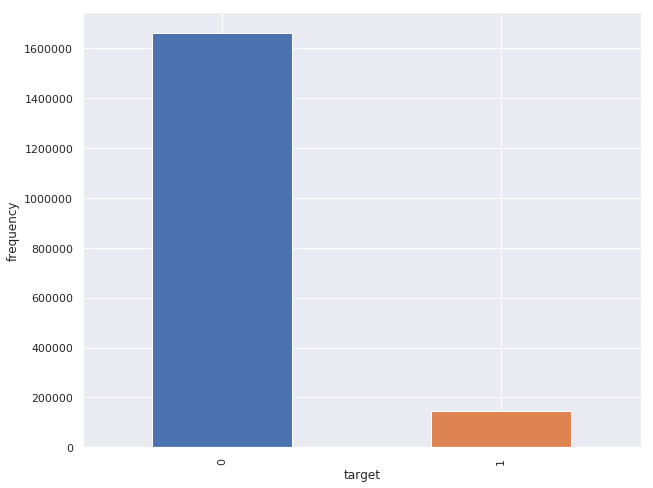

In [8]:
target = data_boolean['target']
fig_std=(10,8)
width = 0.4
target.value_counts().plot(kind='bar', figsize=fig_std).set(xlabel='target', ylabel='frequency') # To see the distribution of 'target' in the data

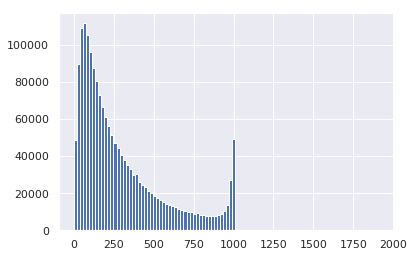

In [9]:
lens = data_boolean.comment_text.str.len()
lens.mean(), lens.std(), lens.max()
lens.hist(bins=100)

In [10]:
#data_boolean.groupby('target').black.hist(bins='fd')
with open('comment.txt', 'w') as f:
    f.writelines(['\n', str(data_boolean['comment_text'])])
    
data_boolean.to_csv('comment.csv')

In [11]:
def data_preprocess(df):
    preprocessed_data = df.copy()
    preprocessed_data['sentence_length'] = preprocessed_data['comment_text'].apply(sent_tokenize).apply(len)
    preprocessed_data['word_length'] = preprocessed_data['comment_text'].apply(word_tokenize).apply(len)
    preprocessed_data['words_per_sentence'] = preprocessed_data['word_length'] / preprocessed_data['sentence_length']   
    return preprocessed_data

# preprocessed_data_boolean = data_preprocess(data_boolean)
# preprocessed_data_boolean.head(5)

In [12]:
X, y = data_boolean["comment_text"], data_boolean["target"]
train_data, dev_data, train_labels, dev_labels = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print('train_data shape: ',train_data.shape)
print('train_labels shape: ',train_labels.shape)
print('dev_data shape: ',dev_data.shape)
print('dev_labels shape: ',dev_labels.shape)

train_data shape:  (1443899,)
train_labels shape:  (1443899,)
dev_data shape:  (360975,)
dev_labels shape:  (360975,)


In [13]:
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data_boolean[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 220
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
train_df, validate_df = train_test_split(data_boolean, test_size=0.2)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))

1443899 train comments, 360975 validate comments


In [15]:
# EMBEDDINGS_PATH = '../input/glove-twitter-27b-200d-txt/glove.twitter.27B.200d.txt'
#EMBEDDINGS_PATH = '../input/glove6b/glove.6B.300d.txt'
EMBEDDINGS_PATH = '../input/glove6b/glove.6B.50d.txt'
EMBEDDINGS_DIMENSION = 50
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005
NUM_EPOCHS = 3
BATCH_SIZE = 256

def train_model(train_df, validate_df, tokenizer):
    # Prepare data
    train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
    train_labels = to_categorical(train_df[TOXICITY_COLUMN])
    validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
    validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])

    # Load embeddings
    print('loading embeddings')
    embeddings_index = {}
    with open(EMBEDDINGS_PATH) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                 EMBEDDINGS_DIMENSION))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # Create model layers.
    def get_convolutional_neural_net_layers():
        """Returns (input_layer, output_layer)"""
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)       
        x =  LSTM(50,dropout=0.1,recurrent_dropout=0.1)(x)
        x =  Dense(50,activation = 'relu')(x)

#         x = Bidirectional(CuDNNLSTM(50,return_sequences=True))       
#         x = Conv1D(128, 2, activation='relu', padding='same')(x)
#         x = MaxPooling1D(5, padding='same')(x)
#         x = Conv1D(128, 3, activation='relu', padding='same')(x)
#         x = MaxPooling1D(5, padding='same')(x)
#         x = Conv1D(128, 4, activation='relu', padding='same')(x)
#         x = MaxPooling1D(40, padding='same')(x)
#         x = Flatten()(x)
#         x = Dropout(DROPOUT_RATE)(x)
#         x = Dense(128, activation='relu')(x)
        preds = Dense(2, activation='softmax')(x)
        return sequence_input, preds

    # Compile model.
    print('compiling model')
    input_layer, output_layer = get_convolutional_neural_net_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    # Train model.
    print('training model')
    model.fit(train_text,
              train_labels,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_labels),
              verbose=2)

    return model
train_start_time = time.time()
model = train_model(train_df, validate_df, tokenizer)
train_stop_time = time.time()

loading embeddings
compiling model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
training model
Instructions for updating:
Use tf.cast instead.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/3
 - 2069s - loss: 0.1813 - acc: 0.9370 - val_loss: 0.1606 - val_acc: 0.9420
Epoch 2/3
 - 2058s - loss: 0.1579 - acc: 0.9432 - val_loss: 0.1501 - val_acc: 0.9456
Epoch 3/3
 - 2068s - loss: 0.1521 - acc: 0.9446 - val_loss: 0.1465 - val_acc: 0.9463


In [16]:
# MODEL_NAME = 'my_model'
# validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]

In [17]:
# validate_df.head()

In [18]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

NameError: name 'MODEL_NAME' is not defined

In [19]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))

NameError: name 'bias_metrics_df' is not defined

In [20]:
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
submission = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')

In [21]:
pred_start_time = time.time()
submission['prediction'] = model.predict(pad_text(test[TEXT_COLUMN], tokenizer))[:, 1]
pred_stop_time = time.time()
submission.to_csv('submission.csv')

In [22]:
print("Total time taken for the kernel: ", (time.time() - start_time)* (1/60), " minutes")
print("Total time taken for training the model: ", (train_stop_time - train_start_time)* (1/60), " minutes")
print("Total time taken for predicting the test data: ", (pred_stop_time - pred_start_time)* (1/60), " minutes")


Total time taken for the kernel:  114.70680298805236  minutes
Total time taken for training the model:  105.09189061323802  minutes
Total time taken for predicting the test data:  6.413999044895172  minutes


In [23]:
model.save("keras_LSTM_glove_50D.h5")
print("Saved model to disk")

Saved model to disk
